In [120]:
import pandas as pd
import datetime as datetime
import numpy as np
import seaborn as sns
from sentence_transformers import SentenceTransformer
import nltk
import re
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')


In [121]:
reviews = pd.read_csv('../data/processed/all_reviews.csv')

/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_25598/4207367361.py:1: DtypeWarning: Columns (5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('../data/processed/all_reviews.csv')


In [122]:
main_df = reviews
print(len(main_df) - len(main_df.drop_duplicates()))
main_df = main_df.drop_duplicates()
main_df.loc[main_df['score'] == 0.0, ['score']]  = 1.0
def spiderman_fix(movie):
    if movie.startswith('spiderman'):
        return movie.replace('spiderman', 'spider-man')
    else:
        return movie
def guardians_fix(x):
    if 'vol-' in x:
        return x.replace('vol-', 'vol.-')
    else:
        return x

main_df.movie = main_df.movie.apply(lambda x: spiderman_fix(x))
main_df.movie = main_df.movie.apply(lambda x: guardians_fix(x))
# main_df.reset_index(inplace=True)
main_df['text_cleaned'] = main_df.text.dropna()
main_df['text_cleaned'] = main_df.text_cleaned.astype(str)
main_df['text_cleaned'] = main_df.text_cleaned.str.lower()
main_df.text_cleaned = main_df.text_cleaned.apply(lambda s: re.sub(r"[0-9]", "number", s))
reviews = main_df.copy()

0


In [123]:
sample = reviews.query('source == "rt_crit" & is_rotten == True').sample(n=100, random_state=1)
sample2 = reviews.query('source == "rt_crit" & is_rotten == False').sample(n=100, random_state=1)
sample = pd.concat([sample, sample2], ignore_index=True)

In [124]:
embeddings = sbert_model.encode(list(sample.text_cleaned))

In [125]:
sample['embedding'] = list(embeddings)
pca = PCA(n_components=2)

In [126]:
pca_1, pca_2 = [], []
for pca1, pca2 in pca.fit_transform(list(sample['embedding'].values)):
    pca_1.append(pca1)
    pca_2.append(pca2)
    # pca_3.append(pca3)
sample['pca1'] = pca_1
sample['pca2'] = pca_2
# sample['pca3'] = pca_3


In [127]:
km = KMeans(n_clusters=2)
preds = km.fit_predict(X=sample[['pca1', 'pca2']], y = sample['is_rotten'])
sample['pred'] = preds

/Users/christianrasmussen/opt/miniconda3/envs/data_wrangling/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='pca1', ylabel='pca2'>

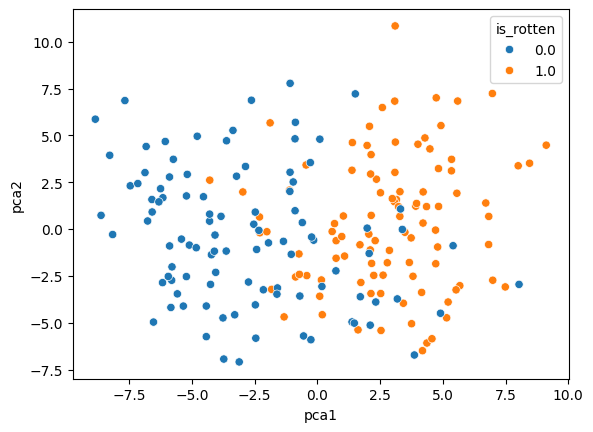

In [128]:
sns.scatterplot(sample, x = 'pca1', y = 'pca2',
                # size=  'pred',
                hue='is_rotten')

In [129]:
print(classification_report(y_pred=preds, y_true=sample['is_rotten']))
sample['rt_status'] = sample['is_rotten']
sample['rt_status'] = sample['is_rotten'].astype(int)
sample['rt_status'] = sample['rt_status'].astype(str).str.replace('0', 'Fresh')
sample['rt_status'] = sample['rt_status'].astype(str).str.replace('1', 'Rotten')



              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       100
         1.0       0.82      0.86      0.84       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200



In [132]:
sample[['pca1', 'pca2', 'rt_status', 'pred']].to_csv('../data/plot_data/cluster_sample.csv')

In [131]:
sample

,Unnamed: 0,index,date,user,score,title,text,url,movie,scrape_date,is_rotten,source,scrape date,text_cleaned,embedding,pca1,pca2,pred,rt_status
0,363520,7344,2023-05-29,Erik Childress,NaN,NaN,Apart from everyone just yelling at one anothe...,https://www.rottentomatoes.com/m/guardians_of_...,guardians-of-the-galaxy-vol.-3,2023-10-21,1.0,rt_crit,2023-10-20,apart from everyone just yelling at one anothe...,"[-0.33915204, 1.2024072, 1.7259625, -0.0870044...",6.712179,1.393277,1,Rotten
1,364208,8032,2014-07-24,Brad Keefe,NaN,NaN,"I predict fans will eat this up, but I was hop...",https://www.rottentomatoes.com/m/guardians_of_...,guardians-of-the-galaxy,2023-10-21,1.0,rt_crit,2023-10-20,"i predict fans will eat this up, but i was hop...","[-0.014421237, -0.5139788, 1.6170521, 0.219208...",-0.447990,3.421208,0,Rotten
2,367361,11185,2008-06-12,Charles Koplinski,NaN,NaN,An Incredible Misfire,https://www.rottentomatoes.com/m/the_incredibl...,the-incredible-hulk,2023-10-21,1.0,rt_crit,2023-10-20,an incredible misfire,"[0.14899608, -0.11602656, 1.4355334, 0.3164501...",1.983210,4.464327,1,Rotten
3,358497,2321,2018-05-04,Stephen Silver,NaN,NaN,"Too many characters, too much plot, too much e...",https://www.rottentomatoes.com/m/avengers_infi...,avengers-infinity-war,2023-10-21,1.0,rt_crit,2023-10-20,"too many characters, too much plot, too much e...","[-0.08210293, -0.10577296, 1.0940849, 0.678194...",-1.110651,2.079354,0,Rotten
4,361893,5717,2022-05-13,Tim Brayton,NaN,NaN,"The story is a scattered bit of chaos, built u...",https://www.rottentomatoes.com/m/doctor_strang...,doctor-strange-in-the-multiverse-of-madness,2023-10-21,1.0,rt_crit,2023-10-20,"the story is a scattered bit of chaos, built u...","[0.21622595, 0.72616047, 1.1686627, 0.38513097...",9.120837,4.478360,1,Rotten
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,362544,6368,2016-11-01,Norman Wilner,NaN,NaN,Doctor Strange fulfills the requirements of a ...,https://www.rottentomatoes.com/m/doctor_strang...,doctor-strange,2023-10-21,0.0,rt_crit,2023-10-20,doctor strange fulfills the requirements of a ...,"[-0.18457675, 1.220112, 0.2449857, 0.28667563,...",2.107003,-5.124123,1,Fresh
196,366815,10639,2016-12-11,Eric Eisenberg,NaN,NaN,What Whedon and Marvel have created here is no...,https://www.rottentomatoes.com/m/marvels_the_a...,avengers-assemble,2023-10-21,0.0,rt_crit,2023-10-20,what whedon and marvel have created here is no...,"[-0.27957422, 0.44756934, 0.28763387, 0.190474...",-5.218353,-2.532883,0,Fresh
197,364405,8229,2010-05-06,Claudia Puig,NaN,NaN,"The action sequences are fun, though not as ex...",https://www.rottentomatoes.com/m/iron_man_2/re...,iron-man-2,2023-10-21,0.0,rt_crit,2023-10-20,"the action sequences are fun, though not as ex...","[-0.007992952, -0.16871461, 0.38061845, 0.6541...",-0.874958,5.697986,0,Fresh
198,366007,9831,2018-10-12,Jared Mobarak,NaN,NaN,The MCU's most family-friendly installment.,https://www.rottentomatoes.com/m/spider_man_ho...,spider-man-homecoming,2023-10-21,0.0,rt_crit,2023-10-20,the mcu's most family-friendly installment.,"[-0.6295221, 0.15368676, 1.3836894, 0.21398817...",-6.059824,4.675475,0,Fresh
